In [194]:
SNAKE_1_Q_TABLE = "s1_qtble_2.npy"
SNAKE_2_Q_TABLE = "s2_qtble_2.npy"

WIDTH = 500
HEIGHT = 500

ROWS = 20


epsilon_reduction = 0.9999999








In [195]:
import pygame
import os

class Cube:
    w = 500

    def __init__(self, start, dirnx=1, dirny=0, color=(255, 0, 0)):
        
        self.pos = start
        self.dirnx = dirnx
        self.dirny = dirny  # "L", "R", "U", "D"
        self.color = color

    def move(self, dirnx, dirny):
        self.dirnx = dirnx
        self.dirny = dirny
        self.pos = (self.pos[0] + self.dirnx, self.pos[1] + self.dirny)

    def draw(self, surface, eyes=False):
        dis = self.w // ROWS
        i = self.pos[0]
        j = self.pos[1]

        pygame.draw.rect(surface, self.color, (i * dis + 1, j * dis + 1, dis - 2, dis - 2))
        
        if eyes:
            centre = dis // 2
            radius = 3
            circleMiddle = (i * dis + centre - radius, j * dis + 8)
            circleMiddle2 = (i * dis + dis - radius * 2, j * dis + 8)
            pygame.draw.circle(surface, (0, 0, 0), circleMiddle, radius)
            pygame.draw.circle(surface, (0, 0, 0), circleMiddle2, radius)

In [196]:
import pygame
import random
import numpy as np


def redrawWindow(snake_1, snake_2, snack, win):
    win.fill((0, 0, 0))
    drawGrid(WIDTH, ROWS, win)
    snake_1.draw(win)
    snake_2.draw(win)
    snack.draw(win)
    pygame.display.update()
    


def drawGrid(w, rows, surface):
    sizeBtwn = w // rows

    x = 0
    y = 0
    for l in range(rows):
        x = x + sizeBtwn
        y = y + sizeBtwn

        pygame.draw.line(surface, (255, 255, 255), (x, 0), (x, w))
        pygame.draw.line(surface, (255, 255, 255), (0, y), (w, y))

    wall_color = (139, 69, 19)  # Brown color
    for i in range(rows):
        pygame.draw.rect(surface, wall_color, (0, i * sizeBtwn, sizeBtwn, sizeBtwn))
        pygame.draw.rect(
            surface,
            wall_color,
            ((rows - 1) * sizeBtwn, i * sizeBtwn, sizeBtwn, sizeBtwn),
        )
        pygame.draw.rect(surface, wall_color, (i * sizeBtwn, 0, sizeBtwn, sizeBtwn))
        pygame.draw.rect(
            surface,
            wall_color,
            (i * sizeBtwn, (rows - 1) * sizeBtwn, sizeBtwn, sizeBtwn),
        )


def randomSnack(rows, item):
    positions = item.body

    while True:
        x = random.randrange(1, rows - 1)
        y = random.randrange(1, rows - 1)
        if len(list(filter(lambda z: z.pos == (x, y), positions))) > 0:
            continue
        else:
            break

    return (x, y)


def save(snake_1, snake_2):
    snake_1.save_q_table(SNAKE_1_Q_TABLE)
    snake_2.save_q_table(SNAKE_2_Q_TABLE)


def reset(snake_1, snake_2):
    snake_1.reset((5, 5))
    snake_2.reset((15, 15))


In [197]:
import random
import random
import numpy as np


class Snake:
    def __init__(self, color, pos, file_name=None):
        self.color = color
        self.head = Cube(pos, color=color)
        self.body = [self.head]
        self.dirnx = 0
        self.dirny = 1
        self.turns = {}
        self.num_of_wins = 0
        self.total_reward = 0
        
        self.q_table = np.load(file_name, allow_pickle=True).item() if file_name and os.path.exists(file_name) else {}

        self.lr = 0.1 
        self.discount_factor = 0.9
        self.epsilon = 0.95
        
        
        
    def get_state(self, snack, other_snake):
        head_x, head_y = self.head.pos
        snack_x, snack_y = snack.pos
        other_head_x, other_head_y = other_snake.head.pos
        
        # Compute differences (distances) between snake head and food, and snake head and other snake's head
        diff_snack_x = abs(head_x - snack_x)
        diff_snack_y = abs(head_y - snack_y)
        diff_other_x = abs(head_x - other_head_x)
        diff_other_y = abs(head_y - other_head_y)
        
        
        # State representation using differences
        state = (diff_snack_x, diff_snack_y, diff_other_x, diff_other_y)
        return state


    def get_optimal_policy(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(4)
        return np.argmax(self.q_table[state])
    
    
    def make_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        else:
            return self.get_optimal_policy(state)

    def update_q_table(self, state, action, next_state, reward):
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(4)
        if state not in self.q_table:
            self.q_table[state] = np.zeros(4)
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * td_error 
        
        

    def move(self, snack, other_snake):
        state = self.get_state(snack, other_snake)
        action = self.make_action(state)

        if action == 0: # Left
            self.dirnx = -1
            self.dirny = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 1: # Right
            self.dirnx = 1
            self.dirny = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 2: # Up
            self.dirny = -1
            self.dirnx = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 3: # Down
            self.dirny = 1
            self.dirnx = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]

        for i, c in enumerate(self.body):
            p = c.pos[:]
            if p in self.turns:
                turn = self.turns[p]
                c.move(turn[0], turn[1])
                if i == len(self.body) - 1:
                    self.turns.pop(p)
            else:
                c.move(c.dirnx, c.dirny)

        # snack, reward, win_self = self.calc_reward(snack, other_snake)
        next_state = self.get_state(snack, other_snake)
        
        
        
        return state, next_state, action
        
    
    def check_out_of_board(self):
        headPos = self.head.pos
        if headPos[0] >= ROWS - 1 or headPos[0] < 1 or headPos[1] >= ROWS - 1 or headPos[1] < 1:
            self.reset((random.randint(3, 18), random.randint(3, 18)))
            return True
        return False
    
    
    def calc_reward(self, snack, other_snake):
        reward = 0
        win_self  = False
        other_win = False

    
        if self.check_out_of_board():
            reward -= 100000
            # win_self = False
            other_win = True
            
            self.reset((random.randint(3, 18), random.randint(3, 18)))
    
        if self.head.pos == snack.pos:
            self.addCube()
            snack = Cube(randomSnack(ROWS, self), color=(0, 255, 0))
            reward += 10000
            self.num_of_wins += 1
    
        if self.head.pos in list(map(lambda z: z.pos, self.body[1:])):
            reward -= 10000
            win_self = False
            other_win = True
            
            self.reset((random.randint(3, 18), random.randint(3, 18)))
    
        if self.head.pos in list(map(lambda z: z.pos, other_snake.body)):
            if self.head.pos != other_snake.head.pos:
                reward -= 10000
                win_self = False
                other_win = True
                
            else:
                if len(self.body) > len(other_snake.body):
                    reward += 10000
                    win_self = True
                    other_win = False
                elif len(self.body) == len(other_snake.body):
                    reward = 0
                else:
                    reward -= 10000
                    win_self = False
                    other_win = True
            self.reset((random.randint(3, 18), random.randint(3, 18)))
    
        distance_to_snack = self.distance_to_snack(snack)
        if not distance_to_snack == 0:
            reward += 1 / distance_to_snack*10000

        # کاهش epsilon
        if self.epsilon > 0.1:
            self.epsilon = self.epsilon * epsilon_reduction
            
        self.total_reward += reward
        
        
        return snack, reward, win_self , other_win   
    
    
        
        

    def avrage_distance_to_other_snake(self, other_snake):
        sum = 0
        for cube in other_snake.body:
            sum += self.distance_to_snack(cube)
        return sum / len(other_snake.body)
    
    def distance_to_snack(self, snack):
        head_x, head_y = self.head.pos
        snack_x, snack_y = snack.pos
        
        # hamilton distance
        return abs(head_x - snack_x) + abs(head_y - snack_y)

    
    def reset(self, pos):
        self.head = Cube(pos, color=self.color)
        self.body = [self.head]
        self.turns = {}
        self.dirnx = 0
        self.dirny = 1
        self.num_of_wins = 0
        

    def addCube(self):
        tail = self.body[-1]
        dx, dy = tail.dirnx, tail.dirny
        

        if dx == 1 and dy == 0:
            self.body.append(Cube((tail.pos[0] - 1, tail.pos[1]), color=self.color))
        elif dx == -1 and dy == 0:
            self.body.append(Cube((tail.pos[0] + 1, tail.pos[1]), color=self.color))
        elif dx == 0 and dy == 1:
            self.body.append(Cube((tail.pos[0], tail.pos[1] - 1), color=self.color))
        elif dx == 0 and dy == -1:
            self.body.append(Cube((tail.pos[0], tail.pos[1] + 1), color=self.color))

        self.body[-1].dirnx = dx
        self.body[-1].dirny = dy

    def draw(self, surface):
        for i, c in enumerate(self.body):
            if i == 0:
                c.draw(surface, True)
            else:
                c.draw(surface)

    def save_q_table(self, file_name):
        np.save(file_name, self.q_table, allow_pickle=True)
        

In [203]:
import pygame
import numpy as np
from tkinter import messagebox

# Initialize pygame and create window
pygame.init()
win = pygame.display.set_mode((WIDTH, HEIGHT))

# Initialize snakes
snake_1 = Snake((255, 0, 0), (15, 15), SNAKE_1_Q_TABLE)
snake_2 = Snake((255, 255, 0), (5, 5), SNAKE_2_Q_TABLE)
snake_1.addCube()
snake_2.addCube()

# Initialize rewards and snack
rewards = []
ss = 0
snack = Cube(randomSnack(ROWS, snake_1), color=(0, 255, 0))
wins = []
episodes = []
clock = pygame.time.Clock()


rr1 = 0
rr2 = 0
while True:
    ss += 1
    reward_1 = 0
    reward_2 = 0
    pygame.time.delay(1)
    clock.tick(10)

    # Handle events
    # for event in pygame.event.get():
    #     if event.type == pygame.QUIT:
    #         if messagebox.askokcancel("Quit", "Do you want to save the Q-tables?"):
    #             save(snake_1, snake_2)
    #         pygame.quit()
    #         exit()
    #     if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
    #         np.save(SNAKE_1_Q_TABLE, snake_1.q_table)
    #         np.save(SNAKE_2_Q_TABLE, snake_2.q_table)
    #         pygame.time.delay

    # Move snakes and calculate new states and rewards
    state_1, new_state_1, action_1 = snake_1.move(snack, snake_2)
    state_2, new_state_2, action_2 = snake_2.move(snack, snake_1)

    snack, reward_1, win_1 , win_2 = snake_1.calc_reward(snack, snake_2)
    snack, reward_2, win_2  , win_1= snake_2.calc_reward(snack, snake_1)
    
    rr1 += reward_1
    rr2 += reward_2
    

    # Track wins
    if win_1 or win_2:
        wins.append([snake_1.num_of_wins, snake_2.num_of_wins])
        rewards.append([rr1, rr2])
        episodes.append(ss)
        print("Win state detected:", (win_1, win_2))
        print("snake_1 wins: ", snake_1.num_of_wins)
        print("snake_2 wins: ", snake_2.num_of_wins)
        print("epsilon: ", snake_1.epsilon)
        print("ss: ", ss)   
        print(len(snake_1.q_table))
        print("rr1: ", rr1)
        print("rr2: ", rr2)
        print("total reward snake 1: ", snake_1.total_reward)
        print("total reward snake 2: ", snake_2.total_reward)
        ss = 0
        
        rr1 = 0
        rr2 = 0
        
    # Update Q-tables
    snake_1.update_q_table(state_1, action_1, new_state_1, reward_1)
    snake_2.update_q_table(state_2, action_2, new_state_2, reward_2)
    


    # Append rewards for analysis
    # rewards.append([reward_1, reward_2])

        
        
        # Optionally reset or reinitialize game state if a win is detected
        # snack = Cube(randomSnack(ROWS, snake_1), color=(0, 255, 0))
        # snake_1.reset((15, 15))
        # snake_2.reset((5, 5))

    # Print debug information
    # print()
    # print("reward_1: ", reward_1)
    # print("reward_2: ", reward_2)
    # print("ss", ss)
    # print("epsilon: ", snake_1.epsilon)

    # Redraw window (uncomment for visualizing the game)
    redrawWindow(snake_1, snake_2, snack, win)


Win state detected: (True, False)
snake_1 wins:  0
snake_2 wins:  0
epsilon:  0.9499993350001998
ss:  7
118908
rr1:  14095.238095238095
rr2:  -4678.821178821179
total reward snake 1:  14095.238095238095
total reward snake 2:  -4678.821178821179
Win state detected: (True, False)
snake_1 wins:  0
snake_2 wins:  0
epsilon:  0.9499988600006276
ss:  5
118908
rr1:  14166.666666666664
rr2:  -6216.269841269841
total reward snake 1:  28261.90476190476
total reward snake 2:  -10895.09102009102
Win state detected: (True, False)
snake_1 wins:  0
snake_2 wins:  0
epsilon:  0.9499869850885084
ss:  125
118908
rr1:  161248.05749805758
rr2:  245174.60317460293
total reward snake 1:  189509.96225996214
total reward snake 2:  234279.5121545119
Win state detected: (True, False)
snake_1 wins:  0
snake_2 wins:  0
epsilon:  0.9499861301005643
ss:  9
118908
rr1:  51666.666666666664
rr2:  -3561.6246498599457
total reward snake 1:  241176.62892662882
total reward snake 2:  230717.88750465194
Win state detected:

KeyboardInterrupt: 

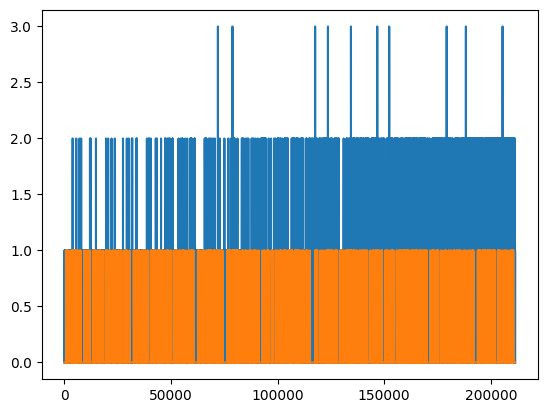

In [201]:
# plt wines 

import matplotlib.pyplot as plt

plt.plot(wins)
plt.show()



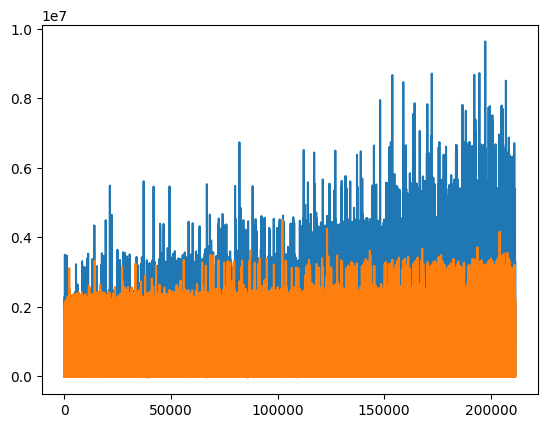

In [202]:
# plt the rewards all of the games

import matplotlib.pyplot as plt

plt.plot(rewards)
plt.show()





In [199]:
snake_1.save_q_table(SNAKE_1_Q_TABLE)
snake_2.save_q_table(SNAKE_2_Q_TABLE)

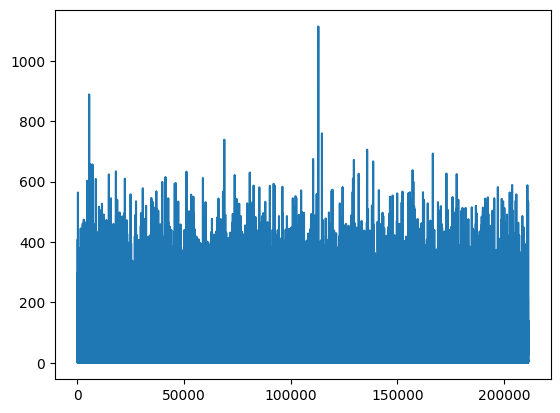

In [200]:
# plt episods

import matplotlib.pyplot as plt

plt.plot(episodes)
plt.show()

